# Комбайны машинного обучения

Для автоматизации и формализации построения решения на базе машинного обучения, придумали большие программные комбайны, которые в одном инструменте пройти все необходимые этапы - от сбора данных до развертки итогового решения.

Есть платные публичные инструменты, такие как Azureml от Microsoft или SageMaker от AWS, есть внутренние инструменты, например Нирвана в Яндексе, а есть и OpenSource аналоги вроде MLFlow.

Сегодня познакомимся с Azureml (поразительно, правда? :) )

Весь ноутбук ниже я запускал со своего локального ноутбука на Ubuntu, а не в облаке.

Для начала поставим необходимые библиотеки для Python

In [ ]:
! pip3 install azureml-train-core azureml-core azureml-automl-runtime matplotlib
! wget -O- https://aka.ms/InstallAzureCLIDeb | sudo bash

И залогинимся

In [ ]:
! az login

Корневой объект - это Workspace. Это область, где будут производиться все дальнейшие операции.

**ВАЖНО** - указывайте свои параметры для subscription_id и resource_group , а не мои :)

In [2]:
from azureml.core import Workspace

ws = Workspace.create(
    name = 'ml-workspace-1',
    subscription_id = '7d1225ca-27cc-40b7-8036-c62a48072ba8',  # Укажите свою подписку
    resource_group = 'lsml-resource-group', # Укажите свою группу
    sku = 'enterprise',
    exist_ok = True
)
ws.get_details()

ws.write_config()

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Deploying KeyVault with name mlworkspkeyvaultd487ae06.
Deploying StorageAccount with name mlworkspstoragec2062ce86.
Deploying AppInsights with name mlworkspinsights6a635315.
Deployed AppInsights with name mlworkspinsights6a635315. Took 8.03 seconds.
Deployed KeyVault with name mlworkspkeyvaultd487ae06. Took 25.74 seconds.
Deployed StorageAccount with name mlworkspstoragec2062ce86. Took 32.11 seconds.
Deploying Workspace with name ml-workspace-1.
Deployed Workspace with name ml-workspace-1. Took 33.01 seconds.


Откройте в браузере появившийся ресурс workspace и нажмите "Запустить студию". Вам откроется интерфейс студии. В ней можно будет сделать все те же операции, что и мы будем делать через Python. И соответственно отслеживать как идут дела.

Задачу будем решать ту же, что и на предыдущем семинаре - будем учить сетку предсказывать тип одежды из fashion mnist.

In [ ]:
! mkdir -p data
! wget -O- https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/fashion-mnist_train.csv.gz | gunzip > data/fashion-mnist_train.csv
! wget -O- https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/fashion-mnist_test.csv.gz | gunzip > data/fashion-mnist_test.csv

Вначале загрузим данные в наше облако. Для хранения файлов сущестует Datastore.

In [3]:
import os
os.getcwd()

'/home/jovyan'

In [4]:
local_files = [ 
    os.getcwd() + "/data/fashion-mnist_train.csv",
    os.getcwd() + "/data/fashion-mnist_test.csv"
]

datastore = ws.get_default_datastore()
datastore.upload_files(files=local_files, target_path='fashion-mnist-data', show_progress=True)

Uploading an estimated of 2 files
Uploading /home/jovyan/data/fashion-mnist_test.csv
Uploaded /home/jovyan/data/fashion-mnist_test.csv, 1 files out of an estimated total of 2
Uploading /home/jovyan/data/fashion-mnist_train.csv
Uploaded /home/jovyan/data/fashion-mnist_train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_7521b0a4348a416299e0183a6e179c11

По какой-то необъяснимой причине для того, чтобы некоторые функции из Azureml, необходимо поставить .NET на локальный компьютер. Чтож, сделаем это

In [ ]:
! wget https://packages.microsoft.com/config/ubuntu/20.04/packages-microsoft-prod.deb -O packages-microsoft-prod.deb
! sudo dpkg -i packages-microsoft-prod.deb

In [ ]:
! apt-get update
! apt-get install -y apt-transport-https
! apt-get update
! apt-get install -y aspnetcore-runtime-2.1

Для того, чтобы данные можно было обрабатывать, их нужно еще собрать в датасеты. Для этого указыаем, из каких файлов в нашем хранилище будет состоять наш датасет и регистрируем его.

In [5]:
from azureml.core.dataset import Dataset

dataset = Dataset.File.from_files(path=(datastore, 'fashion-mnist-data'))

In [6]:
dataset = dataset.register(
    workspace=ws,
    name='fashion-mnist-data',
    description='Fashion mnist data'
)

Далее напишем скрипт обучения. Это обычный скрипт на Python, который как бы запускается из командной строки. Его нужно положить в отдельную директорию. Если для работы скрипта требуются какие-то другие скрипты, то их тоже нужно положить в эту директорию - они все будут доступны из среды выполнения.

In [68]:
! mkdir -p torch-mnist

In [69]:
%%writefile torch-mnist/train.py

from __future__ import print_function, division
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import argparse
import copy
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core.run import Run  # Специальный объект контекста. Он будет использоваться для связью к Azureml
run = Run.get_context()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X


def load_data(data_dir, batch_size = 32):
    train_csv = pd.read_csv("{}/fashion-mnist_train.csv".format(data_dir))
    test_csv = pd.read_csv("{}/fashion-mnist_test.csv".format(data_dir))
    
    y_train = train_csv['label'].values
    X_train = train_csv.drop(['label'],axis=1).values

    y_test = test_csv['label'].values
    X_test = test_csv.drop(['label'],axis=1).values

    torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
    torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
    torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
    torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

    train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
    test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
    return train_loader, test_loader


def fit(model, train_loader, epoch_number=5, batch_size=32):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float().to(device)
            var_y_batch = Variable(y_batch).to(device)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            
            if batch_idx % 200 == 0:
                loss = loss.data
                accuracy = float(correct*100) / float(batch_size*(batch_idx+1))
                run.log('Loss', float(loss))  # Вместо обычных print, используем функцию логгирования.
                run.log('Accuracy', float(accuracy))  # Эти данные будут собираться и отображаться в студии
                
                
def evaluate(model, test_loader, batch_size=32):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float().to(device)
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels.to(device)).sum()
    
    accuracy = float(correct) / (len(test_loader)*batch_size)
    run.log('Test accuracy', accuracy)  # Пишем итоговое качества


def main():
    # Скрипт будет "как-бы" запускаться через командную строку. Поэтому параметры запуска будем получать
    # из аргументов командной строки
    parser = argparse.ArgumentParser()  
    # В следующем параметре указываем директорию, где будут лежать данные для обучения
    # Про то, как они туда попадут - ниже
    parser.add_argument('--data_path', type=str, help='Path to the training data')
    # Директория, куда положить веса модели
    parser.add_argument('--output_dir', type=str, help='output directory')
    
    # Другие параметры модели. Можно добавлять произвольное количество любых параметров
    parser.add_argument('--num_epochs', type=int, default=20, help='number of epochs to train')
    parser.add_argument('--batch_size', type=int, default=32, help='number of examples in one batch')
    args = parser.parse_args()
    
    train_loader, test_loader = load_data(args.data_path, batch_size=args.batch_size)
    
    mlp = MLP()
    mlp.to(device)
    
    fit(mlp, train_loader, epoch_number=args.num_epochs, batch_size=args.batch_size)
    evaluate(mlp, test_loader)
    
    os.makedirs(args.output_dir, exist_ok=True)  # Веса сохраняем в указанную директорию
    torch.save(mlp.state_dict(), os.path.join(args.output_dir, 'model.json'))
    

if __name__ == "__main__":
    main()

Overwriting torch-mnist/train.py


Отдельно необходимо указать, какое окружение для запуска и обучения нам требуется.
В специальном файле пропишем пакеты, которые необходимо установитьэ

In [70]:
%%writefile deps.yaml
channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-defaults
  - torch==1.6.0
  - torchvision==0.7.0
  - future==0.17.1
  - pillow
  - pandas
  - numpy

Overwriting deps.yaml


In [71]:
from azureml.core import Environment

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', file_path = './deps.yaml')

pytorch_env.docker.enabled = True
pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

Создаем объект эксперимента. 

Эксперимент - это набор запусков, которые призваны решить какую-то одну задачу. Например вы хотите находить котиков на картинке. Тогда создайте эксперимент "find-cats-on-picture" и в рамках него попробуйте обучить 10 моделей, которые будут пытаться решить эту задачу.

In [72]:
from azureml.core import Experiment

experiment_name = 'pytorch-fashion'
experiment = Experiment(ws, name=experiment_name)

Для того, чтобы что-то где-то считать, нам нужны вычислительные мощности. Поэтому создадим эластичный кластер в нашем рабочем пространстве. Внутри него будем использвать машины с GPU. Там всегда будет минимально 1 машина, но при необхдимости, кластер будет увеличен в размере до 3 машин.

In [73]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(
        vm_size='Standard_NC6s_v3', # Тип машины с GPU
        vm_priority='lowpriority',
        min_nodes=1, 
        max_nodes=3
    )

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True, timeout_in_minutes=20)

Creating a new compute target...
Creating...
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded......................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


Время запускать обучение. Для этого создаем объект ScriptRunConfig со всеми параметрами.

Чтобы подключить к нашему запуску данные, необходимо использовать функцию `as_mount` созданного нами датасета. Если Azureml увидит в аргументах такой объект, то он подключит зарегистрированные данные к определенной директории и передаст путь до этой директории в параметры.

In [30]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(
    source_directory='torch-mnist',
    script='train.py',
    arguments=[
        '--num_epochs', 30, 
        '--output_dir', './outputs', 
        '--data_path', dataset.as_named_input('input').as_mount(),
        '--batch_size', 32
    ],
    compute_target=compute_target,
    environment=pytorch_env
)

Запускаем эксперимент. Перый запуск обычно идет долго. Следить за тем, как там дела у запуска можно из бразера. Можно найти эксперимент в браузере самостоятельно или открыть первую ссылку, которая будет напечана после запуска ячейки

In [31]:
run = experiment.submit(src)
run.wait_for_completion(show_output = True)

RunId: pytorch-fashion_1615367971_6d957c76
Web View: https://ml.azure.com/experiments/pytorch-fashion/runs/pytorch-fashion_1615367971_6d957c76?wsid=/subscriptions/7d1225ca-27cc-40b7-8036-c62a48072ba8/resourcegroups/lsml-resource-group/workspaces/ml-workspace-1

Streaming azureml-logs/20_image_build_log.txt

2021/03/10 09:19:47 Downloading source code...
2021/03/10 09:19:49 Finished downloading source code
2021/03/10 09:19:49 Creating Docker network: acb_default_network, driver: 'bridge'
2021/03/10 09:19:49 Successfully set up Docker network: acb_default_network
2021/03/10 09:19:49 Setting up Docker configuration...
2021/03/10 09:19:50 Successfully set up Docker configuration
2021/03/10 09:19:50 Logging in to registry: 837da93f0d2546bfb509d7917f056196.azurecr.io
2021/03/10 09:19:51 Successfully logged into 837da93f0d2546bfb509d7917f056196.azurecr.io
2021/03/10 09:19:51 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/03/10 09:

Ran pip subprocess with arguments:
['/azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf/bin/python', '-m', 'pip', 'install', '-U', '-r', '/azureml-environment-setup/condaenv.nkgg5w1x.requirements.txt']
Pip subprocess output:
  Created wheel for future: filename=future-0.17.1-py3-none-any.whl size=488729 sha256=cd4b41a289be3bc53b58af50a6a992c59fafa467d5eeaaab686725c2d7134c88
  Stored in directory: /root/.cache/pip/wheels/c4/f0/e2/8e4ecc9e1b12a428a7657ba683576d3e79d0a75982f63e8fd2
  Created wheel for json-logging-py: filename=json_logging_py-0.2-py3-none-any.whl size=3923 sha256=28ed53f1533193330063e7e5c9813c96c5b49262897b148bd290c4c290f64b31
  Stored in directory: /root/.cache/pip/wheels/e2/1d/52/535a274b9c2ce7d4064838f2bdb62013801281ef7d7f21e2ee
  Created wheel for fusepy: filename=fusepy-3.0.1-py3-none-any.whl size=10502 sha256=adcc75230437e9f38b26c00d0039f5a6fb792c4af209eb17ad7e95f86809972a
  Stored in directory: /root/.cache/pip/wheels/21/5c/83/1dd7e8a232d12227e5410120f4374b33ad

Removing intermediate container 41376c0b5a3a
 ---> 63c27ef4ff77
Step 9/18 : ENV PATH /azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf/bin:$PATH
 ---> Running in 47f8d82c4a29
Removing intermediate container 47f8d82c4a29
 ---> 874da133205b
Step 10/18 : COPY azureml-environment-setup/send_conda_dependencies.py azureml-environment-setup/send_conda_dependencies.py
 ---> f8b9411bb8e4
Step 11/18 : COPY azureml-environment-setup/environment_context.json azureml-environment-setup/environment_context.json
 ---> 195bb49db862
Step 12/18 : RUN python /azureml-environment-setup/send_conda_dependencies.py -p /azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf
 ---> Running in 86d0802313e6
Report materialized dependencies for the environment
Reading environment context
Exporting conda environment
Sending request with materialized conda environment details
Successfully sent materialized environment details
Removing intermediate container 86d0802313e6
 ---> 621b4904ca78
Step 13/18 : ENV AZUREML

{'runId': 'pytorch-fashion_1615367971_6d957c76',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2021-03-10T09:37:06.874265Z',
 'endTimeUtc': '2021-03-10T09:40:55.874578Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'c29bf0aa-4e8e-4a64-a345-d9e1c384f763',
  'azureml.git.repository_uri': 'git@github.com:ADKosm/lsml-2021-internal.git',
  'mlflow.source.git.repoURL': 'git@github.com:ADKosm/lsml-2021-internal.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '4930b05f6a80ba0707e4a0c958d4c990c07254ac',
  'mlflow.source.git.commit': '4930b05f6a80ba0707e4a0c958d4c990c07254ac',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'c5ccb8c4-acfd-4995-b18a-7796cf9e5753'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input', 'mechanism': 'Mount'}}],

После успешного запуска полученную модель можно сохранить. Для этого используем метод `register_model`, где указываем, в какую директорию мы сохранили веса нашей модели.

In [32]:
model = run.register_model(model_name='mnist-fashion-torch-mlp', model_path='outputs')

In [75]:
model

Model(workspace=Workspace.create(name='ml-workspace-1', subscription_id='7d1225ca-27cc-40b7-8036-c62a48072ba8', resource_group='lsml-resource-group'), name=mnist-fashion-torch-mlp, id=mnist-fashion-torch-mlp:1, version=1, tags={}, properties={})

Следующий важный шаг - развернуть полученную модель в облаке, чтобы можно было сделать запрос по HTTP и получить предсказание.

Для этого необходимо реализовать питон-скрипт, в котором будут две функции

* `init` - она будет запущена 1 раз при инициализации. В ней нужно подготовить модеть к запуску
* `run` - она принимает тело запроса, которое пришло на эндпоинт и должно вернуть предсказание по этим данным

In [76]:
%%writefile torch-mnist/score.py

import os
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import json

from azureml.core.model import Model


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X


def init():
    global model
    
    model = MLP()
    
    model_root = Model.get_model_path('mnist-fashion-torch-mlp')  # Через инструмент Model понимаем, где веса модели
    model_path = os.path.join(model_root, 'model.json')
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Загружаем веса
    
    model.eval()


def run(input_data):
    # В input_data - данные, которые прилетели от пользователя
    input_data = Variable(torch.from_numpy(np.array(json.loads(input_data)['data'])).type(torch.LongTensor).float())

    softmax = nn.Softmax(dim=1)
    out = model(input_data)
    pred_probs = softmax(out)
    index = torch.argmax(pred_probs[0]).item()
    
    return {'label': index, "probability": pred_probs[0][index].item()}  # Возвращаем предсказание (формат может быть любым)

Overwriting torch-mnist/score.py


Указываем, где лежит этот скрипт, какое ему нужно окружение, какие мощности нужны для работы модели и запускает процесс развертки. Он тоже не слишком быстрый.

In [77]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(entry_script="torch-mnist/score.py", environment=pytorch_env)

aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1, 
    memory_gb=1, 
    tags={'data': 'fashion-mnist', 'framework':'pytorch'},
    description='Classify clothes'
)

service = Model.deploy(
    workspace=ws, 
    name='fashin-mnist-torch-inf',
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig
)

service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running..........................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [49]:
print(service.get_logs())

/bin/bash: /azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf/lib/libtinfo.so.5: no version information available (required by /bin/bash)
2021-03-10T09:58:20,636215200+00:00 - rsyslog/run 
2021-03-10T09:58:20,655107300+00:00 - iot-server/run 
2021-03-10T09:58:20,661433200+00:00 - gunicorn/run 
bash: /azureml-envs/azureml_b12a18c42a13060a35e6f25ecbe6a0bf/lib/libtinfo.so.5: no version information available (required by bash)
2021-03-10T09:58:20,724263600+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
/bin/bash: /azureml

По итогу получаем специальный URL, на который можно слать HTTP запросы и получать ответы

In [50]:
service.scoring_uri

'http://133d198e-aaa7-4fc9-a206-3d25af84b44e.westus.azurecontainer.io/score'

Загрузим данные локально и сделаем такой запрос

In [78]:
import pandas as pd

df = pd.read_csv('data/fashion-mnist_test.csv')

In [79]:
X_test = df.drop(['label'],axis=1).values
y_test = df['label'].values

In [80]:
import matplotlib.pyplot as plt

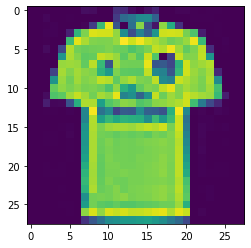

In [81]:
plt.imshow(X_test[0].reshape(28, 28))

In [82]:
y_test[0]

0

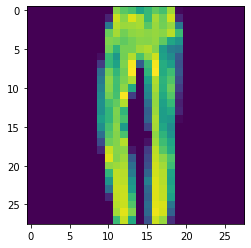

In [83]:
plt.imshow(X_test[1].reshape(28, 28))

In [84]:
y_test[1]

1

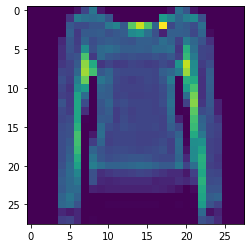

In [85]:
plt.imshow(X_test[2].reshape(28, 28))

In [86]:
y_test[2]

2

In [89]:
import requests

r_data = [X_test[2].tolist()]

r = requests.post(service.scoring_uri, json={
    'method': 'predict',
    'data': r_data
})
print(r.content)

b'{"label": 2, "probability": 0.9100812077522278}'


In [40]:
X_test[0].tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 8,
 0,
 0,
 34,
 29,
 7,
 0,
 11,
 24,
 0,
 0,
 3,
 3,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 44,
 88,
 99,
 122,
 123,
 80,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 3,
 46,
 174,
 249,
 67,
 0,
 94,
 210,
 61,
 14,
 212,
 157,
 37,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 23,
 168,
 206,
 242,
 239,
 238,
 214,
 125,
 61,
 113,
 74,
 133,
 236,
 238,
 236,
 203,
 184,
 20,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 175,
 245,
 223,
 207,
 205,
 206,
 216,
 255,
 237,
 251,
 232,
 223,
 212,
 200,
 205,
 216,
 249,
 173,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 7,
 0,
 53,
 225,
 201,
 197,
 200,
 201,
 206,
 199,
 197,
 185,
 194,
 204,
 232,
 226,
 249,
 219,
 194,
 205,
 229,
 33,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 133,
 223,
 208,
 192,
 195,
 233,
 226,
 216,
 191,
 210,
 188,
 236,
 186,
 0,
 50,
 234,
 207,
 208,
 231,
 133,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 216,
 218,
 216,
 194,
 229,

В azureml встроены много инструментов, которые призваны решить достаточно сложные инженерные проблемы. Например - простой и удобный запуск распределенного обучения. 

Сайчас попробуем решить ту же самую задачу, но используя фреймворк распределенного обучения Horovod

В зависимости дополнительно необходимо прописать библиотеку horovod

In [90]:
%%writefile dist-deps.yaml
channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-defaults
  - torch==1.6.0
  - torchvision==0.7.0
  - horovod==0.19.1
  - future==0.17.1
  - pillow
  - pandas
  - numpy

Overwriting dist-deps.yaml


In [91]:
from azureml.core import Environment

dist_pytorch_env = Environment.from_conda_specification(name = 'dist-pytorch-1.6-gpu', file_path = './dist-deps.yaml')

dist_pytorch_env.docker.enabled = True
dist_pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

Сам скрипт необходимо незначительно обновить, добавив элементы распределенной синхронизации

In [92]:
! mkdir -p dist-torch/

In [93]:
%%writefile dist-torch/train.py

from __future__ import print_function, division
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import argparse
import copy
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import horovod.torch as hvd


from azureml.core.run import Run
run = Run.get_context()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hvd.init()  # Инициализируем хоровод


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X


def load_data(data_dir, batch_size = 32):
    train_csv = pd.read_csv("{}/fashion-mnist_train.csv".format(data_dir))
    test_csv = pd.read_csv("{}/fashion-mnist_test.csv".format(data_dir))
    
    y_train = train_csv['label'].values
    X_train = train_csv.drop(['label'],axis=1).values

    y_test = test_csv['label'].values
    X_test = test_csv.drop(['label'],axis=1).values

    torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
    torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
    torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
    torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

    train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
    test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

    
    # Данные дополнительно нужно опернуть в DistributedSampler, чтобы каждый воркер понимал, какую часть данных он обрабатывает
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train, 
        num_replicas=hvd.size(), # hvd.size возвращает общее количесто воркеров
        rank=hvd.rank()  # hvd.rank возвращает номер текущего воркера
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test,
        num_replicas=hvd.size(),
        rank=hvd.rank()
    )
    
    train_loader = torch.utils.data.DataLoader(
        train, 
        batch_size = batch_size, 
        sampler=train_sampler, 
        shuffle = False
    )
    test_loader = torch.utils.data.DataLoader(
        test, 
        batch_size = batch_size, 
        sampler=test_sampler, 
        shuffle = False
    )
    
    return train_loader, train_sampler, test_loader


def fit(model, train_loader, train_sampler, epoch_number=20, batch_size=32, lr=0.001, momentum=0.9):
    hvd.broadcast_parameters(model.state_dict(), root_rank=0)
       
    optimizer = torch.optim.Adam(model.parameters())
#     optimizer = optim.SGD(
#         model.parameters(), 
#         lr=lr * hvd.size(),
#         momentum=momentum
#     )
    
    # Чтобы градиент считался распределенно, достаточно обернуть оптимизатор в DistributedOptimizer
    optimizer = hvd.DistributedOptimizer(  
        optimizer,
        named_parameters=model.named_parameters()
    )
    
    error = nn.CrossEntropyLoss()
    model.train()
    
    # Далее сам процесс обучения идет как обычно
    for epoch in range(epoch_number):
        train_sampler.set_epoch(epoch)
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float().to(device)
            var_y_batch = Variable(y_batch).to(device)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            
            if batch_idx % 200 == 0:
                loss = loss.data
                accuracy = float(correct*100) / float(batch_size*(batch_idx+1))
                run.log('Loss', float(loss))
                run.log('Accuracy', float(accuracy))
                
                
def evaluate(model, test_loader, batch_size=32):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float().to(device)
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels.to(device)).sum()

    accuracy = float(correct) / (len(test_loader)*batch_size)
    
    accuracy_tensor = torch.tensor(accuracy)
    # Чтобы корректно подсчитать качество на датасете, нужно сложить все данные со всех воркеров
    # Для этого пользуемся функцией allreduce , которая засинхронизируем данные 
    avg_tensor = hvd.allreduce(accuracy_tensor, name='avg_accuracy')
    result = avg_tensor.item()
    
    if hvd.rank() == 0:  # Чтобы итоговое качество было залогированно ровно 1 раз, отправим лог только с 0-го воркера
        run.log('Test accuracy', result)


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_path', type=str, help='Path to the training data')
    parser.add_argument('--output_dir', type=str, help='output directory')
    parser.add_argument('--num_epochs', type=int, default=20, help='number of epochs to train')
    parser.add_argument('--batch_size', type=int, default=32, help='number of examples in one batch')
    parser.add_argument('--lr', type=float, default=0.0001, help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, help='SGD momentum (default: 0.5)')
    args = parser.parse_args()
    
    train_loader, train_sampler, test_loader = load_data(args.data_path, batch_size=args.batch_size)
    
    mlp = MLP()
    mlp.to(device)
    
    fit(mlp, train_loader, train_sampler, epoch_number=args.num_epochs, batch_size=args.batch_size)
    evaluate(mlp, test_loader)
    
    # Полученную модель будем сохранять только с одного воркера, а не со всех сразу
    if hvd.rank() == 0:
        os.makedirs(args.output_dir, exist_ok=True)
        torch.save(mlp.state_dict(), os.path.join(args.output_dir, 'model.json'))
    

if __name__ == "__main__":
    main()

Overwriting dist-torch/train.py


In [94]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import MpiConfiguration

# Весь скрипт выглядит как обычно за исключением distributed_job_config
src = ScriptRunConfig(
    source_directory='dist-torch',
    script='train.py',
    compute_target=compute_target,
    environment=dist_pytorch_env,
    arguments=[
        '--num_epochs', 30, 
        '--output_dir', './outputs', 
        '--data_path', dataset.as_named_input('input').as_mount(),
        '--batch_size', 32
    ],
    distributed_job_config=MpiConfiguration(node_count=3) # Указываем, что хотим 3 воркера для распределнного обучения
)

In [95]:
run = experiment.submit(src)
run.wait_for_completion(show_output = True)

RunId: pytorch-fashion_1615380733_d09ef41a
Web View: https://ml.azure.com/experiments/pytorch-fashion/runs/pytorch-fashion_1615380733_d09ef41a?wsid=/subscriptions/7d1225ca-27cc-40b7-8036-c62a48072ba8/resourcegroups/lsml-resource-group/workspaces/ml-workspace-1

Streaming azureml-logs/55_azureml-execution-tvmps_15087d86362e38a40e5a4d79590601ebc2754e1beac8d657e0bd98983025aef5_p.txt

2021-03-10T12:55:04Z Starting output-watcher...
2021-03-10T12:55:04Z IsDedicatedCompute == False, starting polling for Low-Pri Preemption

Streaming azureml-logs/65_job_prep-tvmps_15087d86362e38a40e5a4d79590601ebc2754e1beac8d657e0bd98983025aef5_p.txt

[2021-03-10T12:55:31.603206] Entering job preparation.
[2021-03-10T12:55:32.097889] Starting job preparation.
[2021-03-10T12:55:32.097924] Extracting the control code.
[2021-03-10T12:55:32.104506] Waiting for master node to finish fetching and extracting the control code. Will check again in 1 seconds.
[2021-03-10T12:55:33.110064] Finished fetching and extractin


Streaming azureml-logs/75_job_post-tvmps_15087d86362e38a40e5a4d79590601ebc2754e1beac8d657e0bd98983025aef5_p.txt

[2021-03-10T13:02:05.660963] Entering job release
[2021-03-10T13:02:06.641752] job release stage : copy_batchai_cached_logs starting...
[2021-03-10T13:02:06.641791] job release stage : copy_batchai_cached_logs completed...
[2021-03-10T13:02:06.641806] Running in AzureML-Sidecar, starting to exit user context managers...
[2021-03-10T13:02:06.642174] Running Sidecar release cmd...
[2021-03-10T13:02:06.649575] INFO azureml.sidecar.sidecar: Received task: exit_contexts. Running on Linux at /mnt/hostfs/mnt/batch/tasks/shared/LS_root/jobs/ml-workspace-1/azureml/pytorch-fashion_1615380733_d09ef41a/mounts/workspaceblobstore/azureml/pytorch-fashion_1615380733_d09ef41a
Enter __exit__ of DatasetContextManager
Unmounting /mnt/hostfs/mnt/batch/tasks/shared/LS_root/jobs/ml-workspace-1/azureml/pytorch-fashion_1615380733_d09ef41a/wd/tmpgh5en1t6.
Finishing unmounting /mnt/hostfs/mnt/batch/t

{'runId': 'pytorch-fashion_1615380733_d09ef41a',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2021-03-10T12:55:01.895262Z',
 'endTimeUtc': '2021-03-10T13:02:28.354511Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'c930178b-fdd5-4b07-888c-73c0531d72e6',
  'azureml.git.repository_uri': 'git@github.com:ADKosm/lsml-2021-internal.git',
  'mlflow.source.git.repoURL': 'git@github.com:ADKosm/lsml-2021-internal.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '4930b05f6a80ba0707e4a0c958d4c990c07254ac',
  'mlflow.source.git.commit': '4930b05f6a80ba0707e4a0c958d4c990c07254ac',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'c5ccb8c4-acfd-4995-b18a-7796cf9e5753'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input', 'mechanism': 'Mount'}}],

Так как в нашем распоряжении целый кластер, мы можем эффективно подбирать гиперпараметры

In [62]:
! mkdir -p hyperdrive/

In [63]:
%%writefile hyperdrive/train.py

from __future__ import print_function, division
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import argparse
import copy
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core.run import Run
run = Run.get_context()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return X


def load_data(data_dir, batch_size = 32):
    train_csv = pd.read_csv("{}/fashion-mnist_train.csv".format(data_dir))
    test_csv = pd.read_csv("{}/fashion-mnist_test.csv".format(data_dir))
    
    y_train = train_csv['label'].values
    X_train = train_csv.drop(['label'],axis=1).values

    y_test = test_csv['label'].values
    X_test = test_csv.drop(['label'],axis=1).values

    torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
    torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
    torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
    torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

    train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
    test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
    return train_loader, test_loader


def fit(model, train_loader, epoch_number=5, batch_size=32, learning_rate=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    run.log('learning_rate', np.float(learning_rate))
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float().to(device)
            var_y_batch = Variable(y_batch).to(device)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            
            if batch_idx % 200 == 0:
                loss = loss.data
                accuracy = float(correct*100) / float(batch_size*(batch_idx+1))
                run.log('loss', float(loss))
                run.log('accuracy', float(accuracy))
                
                
def evaluate(model, test_loader, batch_size=32):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float().to(device)
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels.to(device)).sum()
    
    accuracy = float(correct) / (len(test_loader)*batch_size)
    # Сохраняем в лог какую-то метрику, которую будет оптимизировать подбором гиперпараметров
    run.log('test_accuracy', accuracy)


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_path', type=str, help='Path to the training data')
    parser.add_argument('--output_dir', type=str, help='output directory')
    parser.add_argument('--num_epochs', type=int, default=20, help='number of epochs to train')
    parser.add_argument('--batch_size', type=int, default=32, help='number of examples in one batch')
    # Этот параметр будет перебирать
    parser.add_argument('--learning_rate', type=float, default=0.3, help='learning rate')

    args = parser.parse_args()
    
    train_loader, test_loader = load_data(args.data_path, batch_size=args.batch_size)
    
    mlp = MLP()
    mlp.to(device)
    
    fit(mlp, train_loader, epoch_number=args.num_epochs, batch_size=args.batch_size, learning_rate=args.learning_rate)
    evaluate(mlp, test_loader)
    
    os.makedirs(args.output_dir, exist_ok=True)
    torch.save(mlp.state_dict(), os.path.join(args.output_dir, 'model.json'))
    

if __name__ == "__main__":
    main()

Writing hyperdrive/train.py


In [64]:
%%writefile hyper-deps.yaml
channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-defaults
  - torch==1.6.0
  - torchvision==0.7.0
  - future==0.17.1
  - pillow
  - pandas
  - numpy

Writing hyper-deps.yaml


In [65]:
from azureml.core import Environment

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', file_path = './hyper-deps.yaml')

pytorch_env.docker.enabled = True
pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

In [ ]:
from azureml.core import ScriptRunConfig
# Создаем обычный конфиг для запуска задачи
src = ScriptRunConfig(
    source_directory='hyperdrive',
    script='train.py',
    arguments=[
        '--num_epochs', 30, 
        '--output_dir', './outputs', 
        '--data_path', dataset.as_named_input('input').as_mount(),
        '--batch_size', 32
    ],
    compute_target=compute_target,
    environment=pytorch_env
)

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, uniform, PrimaryMetricGoal

# Указываем, как именно будет подбирать гиперпараметры. 
# Указанные параметры будут добавлены к аргументам командной строки

param_sampling = RandomParameterSampling( {
        'learning_rate': uniform(0.0005, 0.005),
    }
)

early_termination_policy = BanditPolicy(slack_factor=0.15, evaluation_interval=1, delay_evaluation=10)

hyperdrive_config = HyperDriveConfig(
    run_config=src,
    hyperparameter_sampling=param_sampling, 
    policy=early_termination_policy,
    primary_metric_name='test_accuracy',  # Какую метрику оптимизируем
    primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,  # Как именно оптимизируем - max или min
    max_total_runs=8,  # Сколько вообще делать экспериментов с параметрами
    max_concurrent_runs=4  # Сколько задач можно запустить одноременно на кластере
)


In [ ]:
hyperdrive_run = experiment.submit(hyperdrive_config)

In [ ]:
hyperdrive_run.wait_for_completion(show_output=True)

In [ ]:
# Выбираем самую лучшую модель по метрике
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
print(best_run)

In [ ]:
ws.delete(delete_dependent_resources=True, no_wait=False)